In [1]:
import os
import requests
import torch
import torchaudio
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import io
import torchaudio.transforms as T
import torchaudio.functional as F
import torch.fft as fft
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#housekeeping
#csv_file = "all_tracks-1.csv"
csv_file = "tracks_features.csv"
all_tracks = pd.read_csv(csv_file)
all_tracks = all_tracks.drop_duplicates(subset = ['id'])
data_path = 'C://users/khala/Downloads/tracks' 
root_path = 'C://users/khala/Downloads/specs' 
#data_path = '/content/drive/MyDrive/all_tracks_sg' 
files = os.listdir(data_path)

In [ ]:
def plot_spectrogram(specgram):
    plt.rcParams['savefig.pad_inches'] = 0
    fig, axs = plt.subplots(1, 1)
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    axs.axis('off')
    #axs.set_frame_on(False)
    #plt.box(False)
    
    plt.show()
    

In [ ]:
def save_spec(specgram, filename):
    
    fig, axs = plt.subplots(1, 1)
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    axs.axis('off')
    plt.rcParams['savefig.pad_inches'] = 0
    
    plt.savefig(filename + '.png', bbox_inches='tight')
    plt.close(fig)
    
    



In [ ]:
division = 1
freq_bins = 32
power = 2.8
N = len(files)
data_size = N
c = random.choices(range(N), k=data_size)

def tempo_spec(waveform, sample_rate, tempo, division, freq_bins):
  if tempo == 0:
    return T.Spectrogram(power=2.8)(waveform[0])
  n_fft = 2 * freq_bins - 1
  win_length = None
  hop_length = int(60/tempo * division * sample_rate)
  specgram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
  )
  return specgram(waveform)[0]  
 
dataset = []
re_rate = 32000
for i in c:
  filename = files[i][0:len(files[0])-10]
  features = all_tracks[all_tracks['id'] == filename][['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'id']]
  waveform, sample_rate = torchaudio.load(data_path + '/' + files[i])
  waveform = torch.mean(waveform, dim=0, keepdim=True)
  #waveform = waveform[0][0:int(waveform.shape[1]/2)]
  #waveform = torch.unsqueeze(waveform, 0)
  resampler = T.Resample(sample_rate, re_rate, dtype=waveform.dtype)
  waveform = resampler(waveform)
  #dataset.append([waveform, re_rate, features])

  save_spec(tempo_spec(waveform, re_rate, features.tempo.item(), division, freq_bins), root_path + '/' + features.id.item())

#for i in range(data_size):
  #waveforms = tempo_split(dataset[i][0], dataset[i][1], dataset[i][2].tempo, division)
  #print(tempo_spec(dataset[i][0], dataset[i][1], dataset[i][2].tempo, division, freq_bins).shape)
  #plot_spectrogram(T.Spectrogram(power=power)(dataset[i][0][0]))
  #plot_spectrogram(tempo_spec(dataset[i][0], dataset[i][1], dataset[i][2].tempo, division, freq_bins))
  #save_spec(tempo_spec(waveform, re_rate, features.tempo, division, freq_bins), root_path + '/' + features.id.item())

In [2]:
#image i/o setup
from pathlib import Path
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            shuffle=True, num_workers=0)

In [3]:
#housekeeping
#csv_file = "all_tracks-1.csv"
csv_file = "tracks_features.csv"
all_tracks = pd.read_csv(csv_file)
all_tracks = all_tracks.drop_duplicates(subset = ['id'])
data_path = 'C://users/khala/Downloads/tracks' 
root_path = 'C://users/khala/Downloads/specs' 
#data_path = '/content/drive/MyDrive/all_tracks_sg' 
images = os.listdir(root_path)

In [4]:
#normalize images
import torchvision.transforms as transforms
transform = transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))

In [5]:
N = len(images)
test_size = int(0.2 * N)
train_size = N - test_size
c = random.choices(range(N), k=N)

#setup train and test set: sizes 609 and 100
labels_train = torch.zeros(train_size)
images_train = []

image_tens_train = torch.zeros(train_size, 4, 32, 32) #the tensor containing all train image

for i in range(train_size):
  labels_train[i] = all_tracks[all_tracks['id'] == images[i][0:len(images[1])-4]].danceability.item() #labels: danceability value from csv file
  images_train_temp = transform(read_image(root_path + '/' + images[i])/255)
  image_tens_train[i,:,:,:] = torchvision.transforms.functional.resize(images_train_temp, (32, 32))


In [100]:
for i in range(train_size):
  labels_train[i] = all_tracks[all_tracks['id'] == images[i][0:len(images[1])-4]].danceability.item() #labels: danceability value from csv file

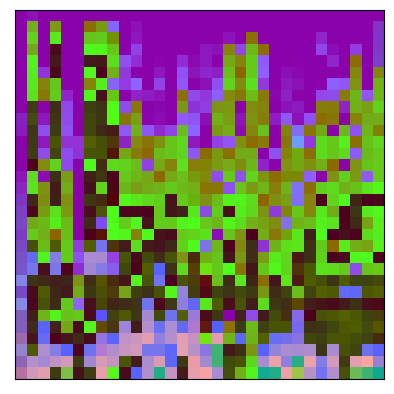

In [27]:
show([image_tens_train[1]])

In [32]:
for i in range(train_size):
  if labels_train[i] == 0:
    labels_train[i] = 0.0000001

In [39]:
labels_train = torch.logit(labels_train).cuda()

In [33]:
labels_test = torch.zeros(test_size)
images_test = []
image_tens_test = torch.zeros(test_size, 4, 32, 32)

for i in range(test_size):
  labels_test[i] = all_tracks[all_tracks['id'] == images[i+train_size][0:len(images[1])-4]].danceability.item()
  images_test_temp = transform(read_image(root_path + '/' + images[i+train_size])/255)
  image_tens_test[i,:,:,:] = torchvision.transforms.functional.resize(images_test_temp, (32, 32))
  

In [29]:
torch.save(image_tens_train, 'C://users/khala/train_tensor.pth')
torch.save(labels_train, 'C://users/khala/train_labels.pth')
torch.save(image_tens_test, 'C://users/khala/test_tensor.pth')
torch.save(labels_test, 'C://users/khala/test_labels.pth')

In [43]:
image_tens_train = image_tens_train.cuda()

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, 1)       
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)   # flatten features

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()
net.cuda()

Net(
  (conv1): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [96]:
import torch.optim as optim
 
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr=0.000004)

In [97]:
for epoch in range(10000):  # loop over the dataset multiple times (here we are not using minibatches)
  optimizer.zero_grad()
  output = net(image_tens_train).squeeze()
 
  loss = criterion(output, labels_train)
  loss.backward()
  optimizer.step()
  loss_running = loss.item()
  print(loss_running)


Streaming output truncated to the last 5000 lines.
0.055853161960840225
0.055851906538009644
0.0558505654335022
0.055849816650152206
0.055847615003585815
0.05584893748164177
0.055846381932497025
0.055846892297267914
0.055846329778432846
0.05584638938307762
0.055847711861133575
0.0558483861386776
0.05585172772407532
0.05585015192627907
0.05584735423326492
0.055844854563474655
0.05584016069769859
0.05583759397268295
0.055834099650382996
0.05583415925502777
0.0558340884745121
0.055833738297224045
0.05583569407463074
0.05583483725786209
0.05583442002534866
0.055833302438259125
0.05582789331674576
0.05582773685455322
0.055824585258960724
0.05582483857870102
0.055824194103479385
0.055821821093559265
0.05582204461097717
0.055820923298597336
0.05581887438893318
0.05582049861550331
0.055817488580942154
0.05581824108958244
0.055815037339925766
0.05581395700573921
0.055812668055295944
0.055810727179050446
0.05581006035208702
0.055809520184993744
0.05580815300345421
0.05580858886241913
0.055806990

KeyboardInterrupt: ignored

In [98]:
net2 = net.cpu()

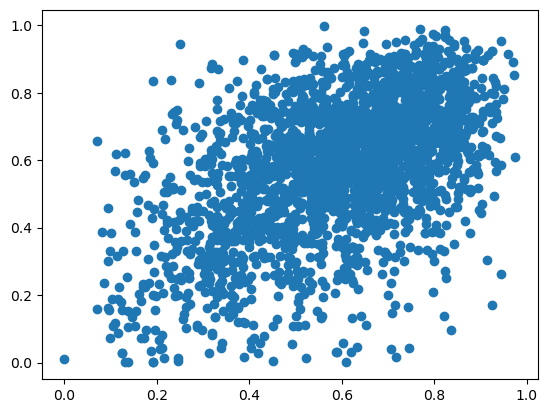

In [99]:
output = torch.zeros(test_size)

import matplotlib.lines as lines
import matplotlib.figure

for i in range(test_size):
  output[i] = torch.sigmoid(net2(image_tens_test[i,:,:,:])) 

plot = plt.scatter(labels_test, output.detach().numpy())
plt.show()

In [ ]:
def tempo_split(waveform, sample_rate, tempo, division):
  t = 60/tempo * division
  num_channels, num_frames = waveform.shape
  frame_size = int(t * sample_rate)
  num_windows = int(num_frames/frame_size)
  if(num_windows == 0):
    return waveform
  waveform_split = torch.zeros(num_windows, frame_size)
  for i in range(num_windows):
    waveform_split[i] = waveform[0][i*frame_size:(i+1)*frame_size]
  return waveform_split